<a href="https://colab.research.google.com/github/larasauser/master/blob/main/Whitt_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === 0) Installer / importer libs et monter Drive ===
!pip install rasterio tqdm scikit-image scikit-learn

import os
from glob import glob
from datetime import datetime
from tqdm import tqdm
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from scipy.linalg import lstsq
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 29.0 MB/s eta 0:00:00
Mounted at /content/drive


In [48]:
# === 1) Paramètres principaux ===
DRIVE_CLEAR_FOLDER = '/content/drive/MyDrive/Whitt/NDVI_grancy_Landsat8'
DRIVE_MASKED_FOLDER = '/content/drive/MyDrive/Whitt/NDVI_grancy_Landsat8_hole'
DRIVE_MODIS_FOLDER = '/content/drive/MyDrive/Whitt/NDVI_grancy_MODIS'
OUTPUT_FOLDER = '/content/drive/MyDrive/Whitt/egfwh_grancy_outputs3'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

WINDOW_METERS = 200.0
KAPPA = 1.0  # Whittaker smoothing
MIN_OVERLAP = 3

In [49]:
# === 2) Fonctions helpers ===
def parse_date_from_filename(fn):
    import re
    m = re.search(r'(\d{4})-(\d{2})-(\d{2})', os.path.basename(fn))
    if m:
        return datetime.strptime(''.join(m.groups()), '%Y%m%d').date()
    return datetime.fromtimestamp(os.path.getmtime(fn)).date()

def read_singleband_tif(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        meta = src.meta.copy()
    nd = meta.get('nodata', None)
    if nd is not None:
        arr[arr==nd] = np.nan
    return arr, meta

def resample_to_target(src_arr, src_meta, target_meta):
    dst_arr = np.full((target_meta['height'], target_meta['width']), np.nan, dtype=np.float32)
    reproject(
        source=src_arr,
        destination=dst_arr,
        src_transform=src_meta['transform'],
        src_crs=src_meta['crs'],
        dst_transform=target_meta['transform'],
        dst_crs=target_meta['crs'],
        resampling=Resampling.bilinear
    )
    return dst_arr

In [50]:
# === 3) Charger et aligner les images ===
# trouver la plus petite image Landsat pour référence
clear_files = sorted(glob(os.path.join(DRIVE_CLEAR_FOLDER, '*.tif')))
masked_files = sorted(glob(os.path.join(DRIVE_MASKED_FOLDER, '*.tif')))
modis_files = sorted(glob(os.path.join(DRIVE_MODIS_FOLDER, '*.tif')))

sizes = []
for f in clear_files:
    arr, meta = read_singleband_tif(f)
    sizes.append((arr.shape[0]*arr.shape[1], f, arr.shape, meta))
sizes.sort()
_, ref_file, ref_shape, ref_meta = sizes[0]
H_ref, W_ref = ref_shape
PIXEL_SIZE_M = abs(ref_meta['transform'][0])
print("Reference Landsat:", os.path.basename(ref_file), "shape:", ref_shape)

# stacks Landsat
landsat_clear_stack, landsat_masked_stack = [], []
clear_dates, masked_dates = [], []

for f in clear_files:
    arr, meta = read_singleband_tif(f)
    if arr.shape != ref_shape:
        arr = resample_to_target(arr, meta, ref_meta)
    landsat_clear_stack.append(arr)
    clear_dates.append(parse_date_from_filename(f))

for f in masked_files:
    arr, meta = read_singleband_tif(f)
    if arr.shape != ref_shape:
        arr = resample_to_target(arr, meta, ref_meta)
    landsat_masked_stack.append(arr)
    masked_dates.append(parse_date_from_filename(f))

landsat_clear_stack = np.stack(landsat_clear_stack, axis=0)
landsat_masked_stack = np.stack(landsat_masked_stack, axis=0)
T, H, W = landsat_clear_stack.shape
print("Stacks shapes (clear/masked):", landsat_clear_stack.shape, landsat_masked_stack.shape)

# === MODIS local stack alignée sur dates Landsat ===
modis_stack = np.full((T, H, W), np.nan, dtype=np.float32)
modis_map = {parse_date_from_filename(f): f for f in modis_files}
modis_dates_list = sorted(modis_map.keys())

for ti, d in enumerate(clear_dates):  # ou common_dates
    diffs = [(abs((md - d).days), md) for md in modis_dates_list]
    nearest_md = min(diffs, key=lambda x: x[0])[1]
    mod_file = modis_map[nearest_md]
    arr, meta = read_singleband_tif(mod_file)
    arr_resampled = resample_to_target(arr, meta, ref_meta)
    modis_stack[ti] = arr_resampled

print("MODIS stack aligned:", modis_stack.shape)

Reference Landsat: NDVI_2013-06-05.tif shape: (344, 319)
Stacks shapes (clear/masked): (174, 344, 319) (6, 344, 319)
MODIS stack aligned: (174, 344, 319)


In [51]:
# === 4) Helpers EGF / Whittaker ===
def pearson_r(a, b):
    valid = ~np.isnan(a) & ~np.isnan(b)
    if valid.sum()<2: return np.nan
    x, y = a[valid], b[valid]
    xm, ym = x.mean(), y.mean()
    num = np.sum((x-xm)*(y-ym))
    den = np.sqrt(np.sum((x-xm)**2)*np.sum((y-ym)**2))
    if den==0: return np.nan
    return num/den

def compute_M_reference_pixel(i,j,modis_stack,sl_target_ts,radius_pix):
    T,H,W = modis_stack.shape
    i0, i1 = max(0,i-radius_pix), min(H,i+radius_pix+1)
    j0, j1 = max(0,j-radius_pix), min(W,j+radius_pix+1)
    coords = [(ii,jj) for ii in range(i0,i1) for jj in range(j0,j1)]
    corrs, mseries = [], []
    for ii,jj in coords:
        ms = modis_stack[:,ii,jj]
        r = pearson_r(ms, sl_target_ts)
        corrs.append(r); mseries.append(ms)
    corrs, mseries = np.array(corrs), np.array(mseries)
    valid_idx = ~np.isnan(corrs)
    if valid_idx.sum()==0: return None
    R = corrs[valid_idx]; ms_valid = mseries[valid_idx]
    R = (R-R.min())/(R.max()-R.min()) if R.max()!=R.min() else np.ones_like(R)
    weights = R / R.sum()
    Mref = np.zeros(T, dtype=float)
    support = np.zeros(T, dtype=float)
    for w, ms in zip(weights, ms_valid):
        valid_t = ~np.isnan(ms)
        Mref[valid_t] += w * ms[valid_t]
        support[valid_t] += w
    Mref[support==0]=np.nan
    return Mref

def estimate_linear_transfer(M_ref, SL_ts):
    valid = ~np.isnan(M_ref) & ~np.isnan(SL_ts)
    if valid.sum()<2: return None
    A = np.vstack([M_ref[valid], np.ones(valid.sum())]).T
    y = SL_ts[valid]
    sol, *_ = lstsq(A, y)
    return sol[0], sol[1]

def whittaker_smoother(y,kappa=1.0):
    n = y.shape[0]; mask = ~np.isnan(y)
    if mask.sum()==0: return np.full_like(y,np.nan)
    out = np.full_like(y,np.nan,dtype=float)
    idx = np.where(mask)[0]
    runs = np.split(idx, np.where(np.diff(idx)!=1)[0]+1)
    for run in runs:
        s,e = run[0], run[-1]+1
        seg = y[s:e].astype(float)
        m = len(seg)
        if m<=2: out[s:e]=seg; continue
        D = np.zeros((m-2,m))
        for r in range(m-2): D[r,r]=1; D[r,r+1]=-2; D[r,r+2]=1
        A_mat = np.eye(m)+kappa*(D.T@D)
        out[s:e] = np.linalg.solve(A_mat, seg)
    return out

In [11]:
# === 5) EGF computation ===
radius_pix = int(round((WINDOW_METERS/2.0)/PIXEL_SIZE_M))
A = np.full((H,W),np.nan); A0 = np.full((H,W),np.nan)
Mref_stack = np.full((T,H,W),np.nan)

print("Estimating M_reference and linear transfer...")
for i in tqdm(range(H)):
    for j in range(W):
        sl_target_ts = landsat_clear_stack[:,i,j]
        Mref = compute_M_reference_pixel(i,j,modis_stack,sl_target_ts,radius_pix)
        if Mref is None:
            i0,i1 = max(0,i-radius_pix), min(H,i+radius_pix+1)
            j0,j1 = max(0,j-radius_pix), min(W,j+radius_pix+1)
            block = modis_stack[:,i0:i1,j0:j1]
            Mref = np.nanmean(block.reshape(T,-1),axis=1)
        Mref_stack[:,i,j] = Mref
        est = estimate_linear_transfer(Mref, sl_target_ts)
        if est is None: continue
        A[i,j], A0[i,j] = est

SLM = np.full((T,H,W),np.nan)
for i in range(H):
    for j in range(W):
        if np.isnan(A[i,j]) or np.isnan(A0[i,j]): continue
        SLM[:,i,j] = Mref_stack[:,i,j]*A[i,j]+A0[i,j]

Estimating M_reference and linear transfer...


100%|██████████| 344/344 [06:19<00:00,  1.10s/it]


In [27]:
# === 5) EGF computation 2 ===
radius_pix = int(round((WINDOW_METERS / 2.0) / PIXEL_SIZE_M))
A = np.full((H, W), np.nan)
A0 = np.full((H, W), np.nan)
Mref_stack = np.full((T, H, W), np.nan)

print("Estimating M_reference and linear transfer...")
for i in tqdm(range(H)):
    for j in range(W):
        sl_target_ts = landsat_clear_stack[:, i, j]
        Mref = compute_M_reference_pixel(i, j, modis_stack, sl_target_ts, radius_pix)
        if Mref is None:
            i0, i1 = max(0, i - radius_pix), min(H, i + radius_pix + 1)
            j0, j1 = max(0, j - radius_pix), min(W, j + radius_pix + 1)
            block = modis_stack[:, i0:i1, j0:j1]
            Mref = np.nanmean(block.reshape(T, -1), axis=1)
        Mref_stack[:, i, j] = Mref
        est = estimate_linear_transfer(Mref, sl_target_ts)
        if est is None:
            continue
        A[i, j], A0[i, j] = est

Estimating M_reference and linear transfer...


100%|██████████| 344/344 [06:25<00:00,  1.12s/it]


In [52]:
# === 5) EGF computation 3 ===
radius_pix = int(round((WINDOW_METERS / 2.0) / PIXEL_SIZE_M))
A = np.full((H, W), np.nan)
A0 = np.full((H, W), np.nan)
Mref_stack = np.full((T, H, W), np.nan)

print("Estimating M_reference and linear transfer...")
for i in tqdm(range(H)):
    for j in range(W):
        sl_target_ts = landsat_clear_stack[:, i, j]
        Mref = compute_M_reference_pixel(i, j, modis_stack, sl_target_ts, radius_pix)
        if Mref is None:
            i0, i1 = max(0, i - radius_pix), min(H, i + radius_pix + 1)
            j0, j1 = max(0, j - radius_pix), min(W, j + radius_pix + 1)
            block = modis_stack[:, i0:i1, j0:j1]
            Mref = np.nanmean(block.reshape(T, -1), axis=1)
        Mref_stack[:, i, j] = Mref
        est = estimate_linear_transfer(Mref, sl_target_ts)
        if est is not None:
            A[i, j], A0[i, j] = est


Estimating M_reference and linear transfer...


100%|██████████| 344/344 [06:32<00:00,  1.14s/it]


In [12]:
# === 6) Combine & Whittaker smoothing ===
integrated = np.where(~np.isnan(landsat_clear_stack), landsat_clear_stack, SLM)
smoothed = np.full_like(integrated,np.nan,dtype=float)
print("Applying Whittaker smoothing per pixel...")
for i in tqdm(range(H)):
    for j in range(W):
        smoothed[:,i,j] = whittaker_smoother(integrated[:,i,j],kappa=KAPPA)


Applying Whittaker smoothing per pixel...


100%|██████████| 344/344 [03:02<00:00,  1.88it/s]


In [29]:
# === 6) Reconstruction using Whittaker smoothing 2 ===
print("Applying EGF model and Whittaker smoothing...")
SLM = np.full((T, H, W), np.nan)
for i in range(H):
    for j in range(W):
        if np.isnan(A[i, j]) or np.isnan(A0[i, j]):
            continue
        SLM[:, i, j] = Mref_stack[:, i, j] * A[i, j] + A0[i, j]

smoothed = np.full_like(SLM, np.nan, dtype=float)
for i in tqdm(range(H)):
    for j in range(W):
        smoothed[:, i, j] = whittaker_smoother(SLM[:, i, j], kappa=KAPPA)

# === 6b) Inject reconstruction ONLY into masked pixels ===
print("Merging reconstructed values into masked images only...")

# Créer le stack final : start from masked images (avec NaN)
final_stack = landsat_masked_stack.copy()

# Pour chaque image masked
for t in range(len(masked_dates)):
    gap_mask = np.isnan(final_stack[t])  # pixels manquants
    final_stack[t, gap_mask] = smoothed[t, gap_mask]  # inject reconstruction uniquement là où il y avait NaN


Applying EGF model and Whittaker smoothing...


100%|██████████| 344/344 [02:58<00:00,  1.92it/s]

Merging reconstructed values into masked images only...


In [53]:
# === 6) Reconstruction temporaire 3 ===
SLM = np.full((T, H, W), np.nan)
for i in range(H):
    for j in range(W):
        if not np.isnan(A[i, j]) and not np.isnan(A0[i, j]):
            SLM[:, i, j] = Mref_stack[:, i, j] * A[i, j] + A0[i, j]

# === 6b) Reconstruction uniquement sur les gaps + Whittaker ===
final_stack = landsat_masked_stack.copy()  # start from masked images (NaN sur gaps)
print("Merging reconstructed values into masked pixels and applying Whittaker smoothing...")

for t in range(len(masked_dates)):
    gap_mask = np.isnan(final_stack[t])

    # Crée un array temporaire pour stocker la reconstruction Whittaker uniquement sur gaps
    smoothed_gap = np.full((H, W), np.nan)

    for i in range(H):
        for j in range(W):
            if gap_mask[i, j]:
                # appliquer Whittaker sur la série temporelle du pixel
                smoothed_gap[i, j] = whittaker_smoother(SLM[:, i, j], kappa=KAPPA)[t]

    # Injection finale uniquement sur les gaps
    final_stack[t, gap_mask] = smoothed_gap[gap_mask]

Merging reconstructed values into masked pixels and applying Whittaker smoothing...


In [15]:
# === 7) Save reconstructed images & optional metrics ===
def write_tif(path, arr, meta_template):
    meta = meta_template.copy()
    meta.update({'count': 1, 'dtype': 'float32', 'nodata': None})  # on garde les NaN
    out = arr.astype(np.float32)
    with rasterio.open(path, 'w', **meta) as dst:
        dst.write(out, 1)

target_indices = [ti for ti, d in enumerate(masked_dates)]
for t in target_indices:
    outpath = os.path.join(OUTPUT_FOLDER, f'recon_{masked_dates[t]}.tif')
    write_tif(outpath, smoothed[t], ref_meta)
    print("Saved", outpath)

print("Finished. Reconstructions available in:", OUTPUT_FOLDER)

Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs/recon_2013-04-18.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs/recon_2013-09-25.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs/recon_2018-05-25.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs/recon_2018-10-09.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs/recon_2023-05-23.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs/recon_2023-11-08.tif
Finished. Reconstructions available in: /content/drive/MyDrive/Whitt/egfwh_grancy_outputs


In [30]:
# === 7) Save reconstructed images as GeoTIFF 2 ===
def write_tif_nan(path, arr, meta_template):
    meta = meta_template.copy()
    meta.update({'count': 1, 'dtype': 'float32', 'nodata': None})  # conserve les NaN
    with rasterio.open(path, 'w', **meta) as dst:
        dst.write(arr.astype(np.float32), 1)

print("Saving reconstructed GeoTIFFs...")
for t, date in enumerate(masked_dates):
    outpath = os.path.join(OUTPUT_FOLDER, f'recon_{date}.tif')
    write_tif_nan(outpath, final_stack[t], ref_meta)
    print("Saved", outpath)

print("✅ Finished. Reconstructions available in:", OUTPUT_FOLDER)

Saving reconstructed GeoTIFFs...
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs2/recon_2013-04-18.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs2/recon_2013-09-25.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs2/recon_2018-05-25.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs2/recon_2018-10-09.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs2/recon_2023-05-23.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs2/recon_2023-11-08.tif
✅ Finished. Reconstructions available in: /content/drive/MyDrive/Whitt/egfwh_grancy_outputs2


In [54]:
# === 7) Sauvegarde GeoTIFF 3 ===
def write_tif_nan(path, arr, meta_template):
    meta = meta_template.copy()
    meta.update({'count': 1, 'dtype': 'float32', 'nodata': None})  # conserve les NaN
    with rasterio.open(path, 'w', **meta) as dst:
        dst.write(arr.astype(np.float32), 1)

print("Saving reconstructed GeoTIFFs...")
for t, date in enumerate(masked_dates):
    outpath = os.path.join(OUTPUT_FOLDER, f'recon_{date}.tif')
    write_tif_nan(outpath, final_stack[t], ref_meta)
    print("Saved", outpath)
print("✅ Finished. Reconstructions available in:", OUTPUT_FOLDER)

Saving reconstructed GeoTIFFs...
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs3/recon_2013-04-18.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs3/recon_2013-09-25.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs3/recon_2018-05-25.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs3/recon_2018-10-09.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs3/recon_2023-05-23.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs3/recon_2023-11-08.tif
✅ Finished. Reconstructions available in: /content/drive/MyDrive/Whitt/egfwh_grancy_outputs3


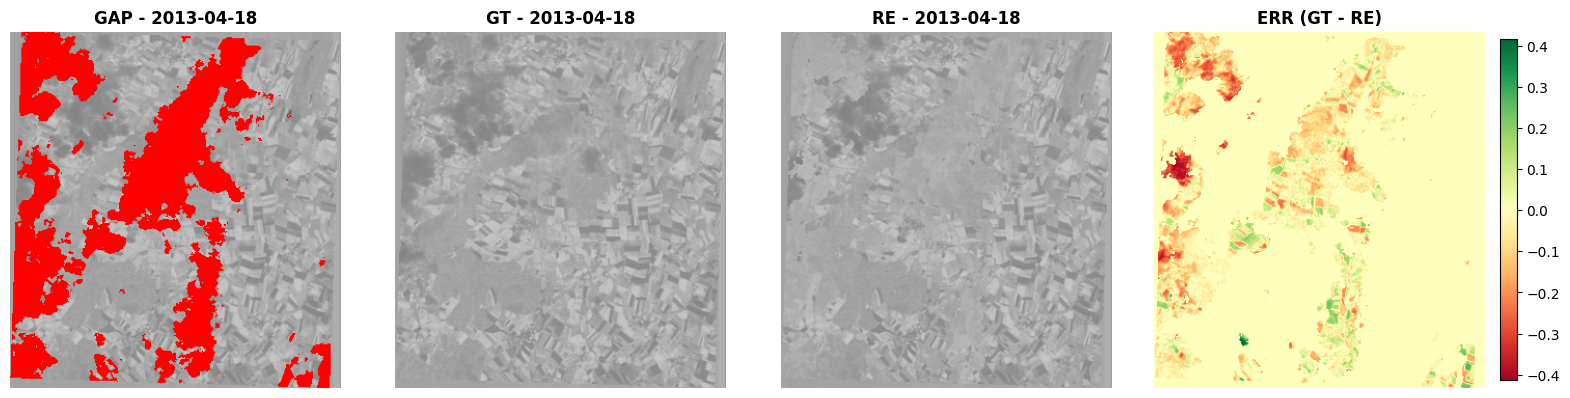

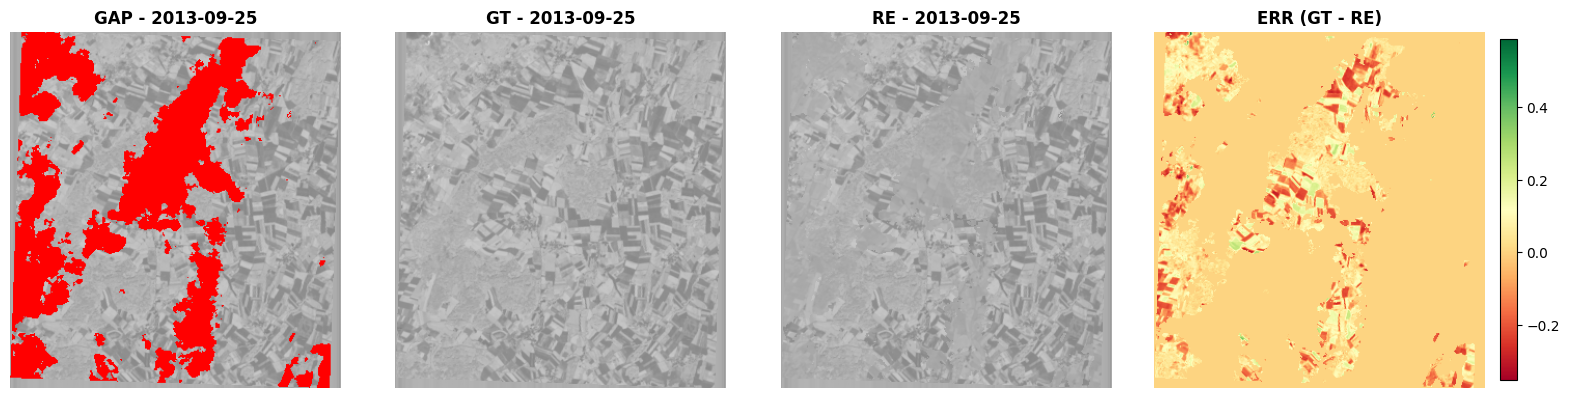

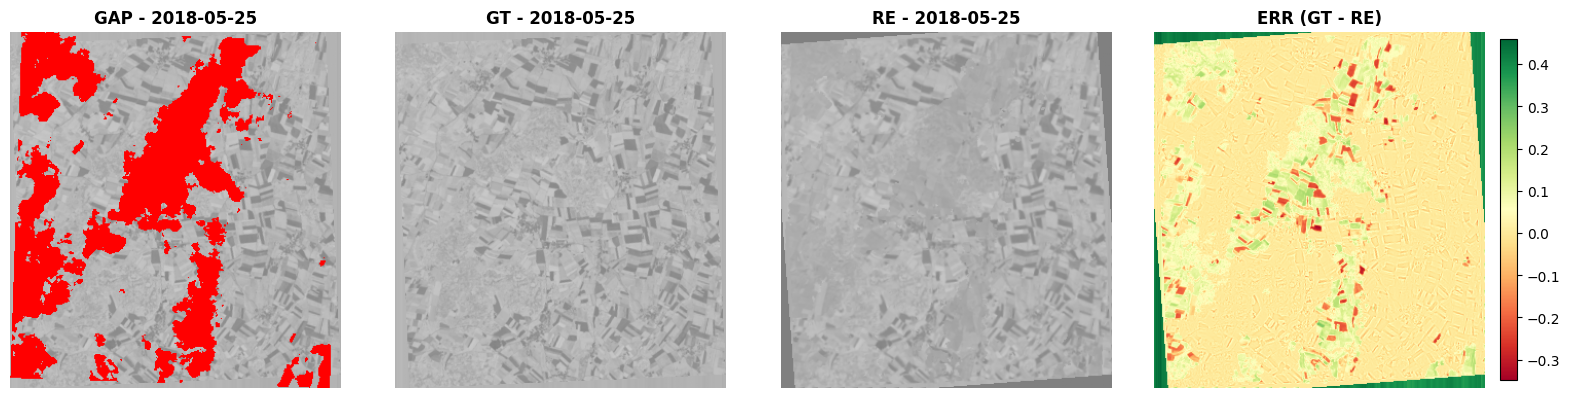

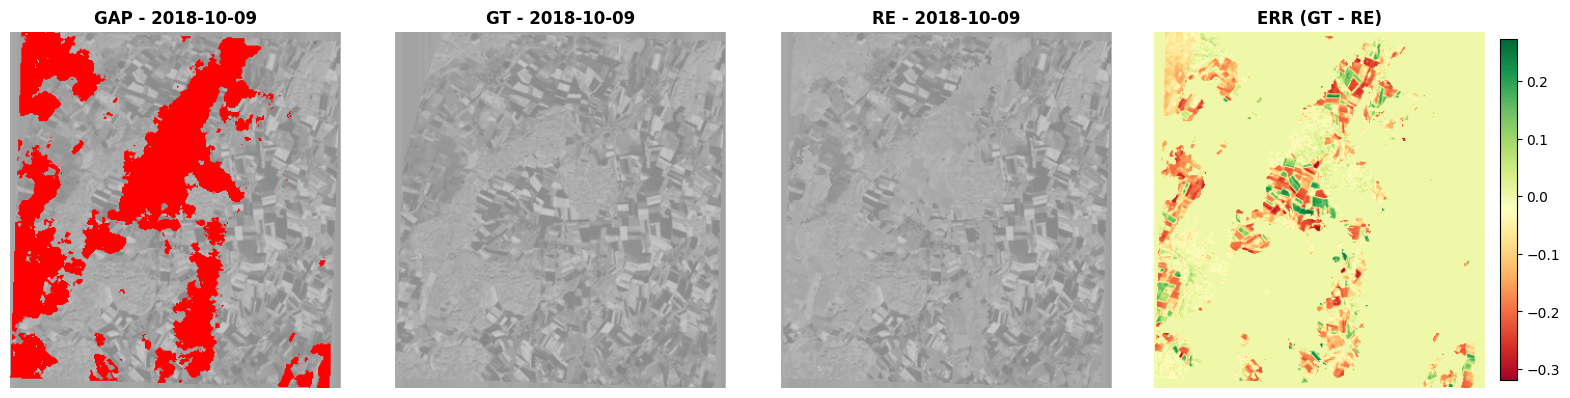

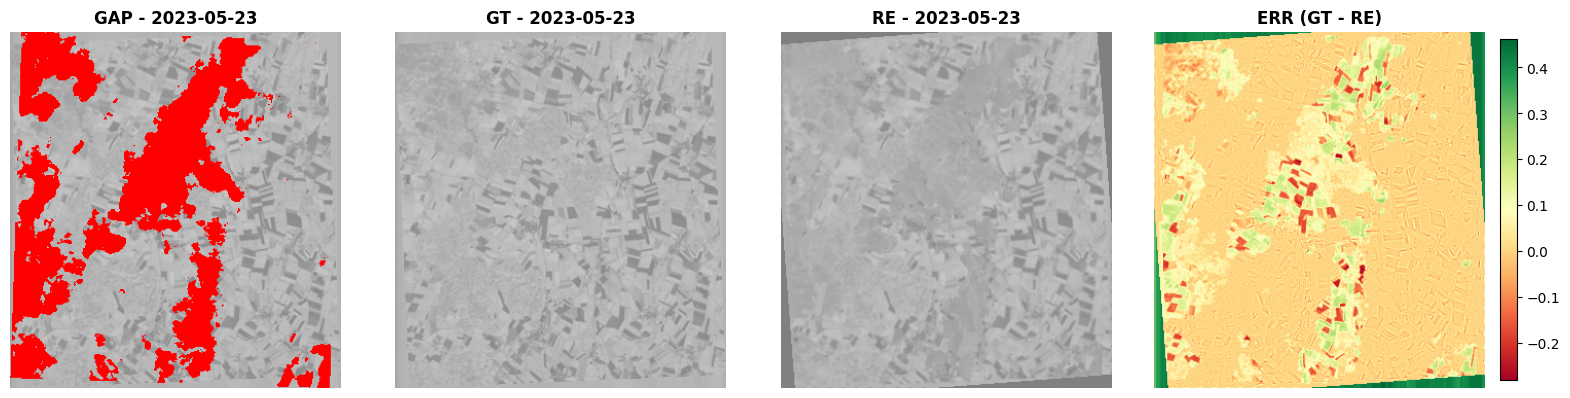

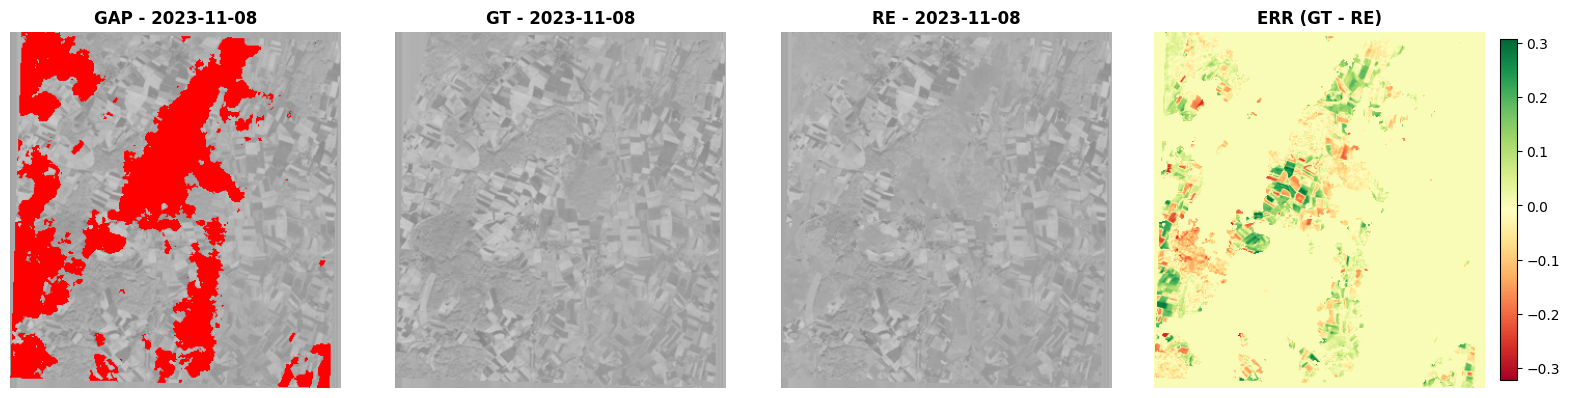

In [55]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from rasterio.warp import reproject, Resampling
import rasterio
import os
from glob import glob

# === Dossiers ===
hole_dir = '/content/drive/MyDrive/Whitt/NDVI_grancy_Landsat8_hole'
gt_dir = '/content/drive/MyDrive/Whitt/NDVI_grancy_full'
recon_dir = '/content/drive/MyDrive/Whitt/egfwh_grancy_outputs3'

# === Liste des fichiers ===
hole_files = sorted(glob(os.path.join(hole_dir, '*.tif')))
gt_files = sorted(glob(os.path.join(gt_dir, '*.tif')))
recon_files = sorted(glob(os.path.join(recon_dir, 'recon_*.tif')))

# === Fonctions utilitaires ===
def read_tif_with_meta(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        meta = src.meta.copy()
    arr[arr == meta.get('nodata', -9999)] = np.nan
    return arr, meta

def resample_to_match(source_arr, source_meta, target_meta):
    dst_arr = np.empty((target_meta['height'], target_meta['width']), dtype=np.float32)
    reproject(
        source=source_arr,
        destination=dst_arr,
        src_transform=source_meta['transform'],
        src_crs=source_meta['crs'],
        dst_transform=target_meta['transform'],
        dst_crs=target_meta['crs'],
        resampling=Resampling.bilinear
    )
    return dst_arr

# === Visualisation ===
for i in range(len(hole_files)):
    fname = os.path.basename(hole_files[i])
    date = fname.replace('NDVI_', '').replace('.tif', '')

    # Lecture de l'image trouée (référence)
    hole, hole_meta = read_tif_with_meta(hole_files[i])

    # Lecture et alignement des GT et reconstruction
    gt, gt_meta = read_tif_with_meta(gt_files[i])
    gt_resampled = resample_to_match(gt, gt_meta, hole_meta)

    recon, recon_meta = read_tif_with_meta(recon_files[i])
    recon_resampled = resample_to_match(recon, recon_meta, hole_meta)

    # Crée un masque des gaps (NaN dans hole)
    gap_mask = np.isnan(hole)

    # Calcul de l'erreur uniquement sur les pixels des gaps
    err = np.full_like(hole, np.nan)
    valid_mask = gap_mask & ~np.isnan(gt_resampled) & ~np.isnan(recon_resampled)
    #err[valid_mask] = gt_resampled[valid_mask] - recon_resampled[valid_mask]
    err = gt_resampled - recon_resampled
    # === Figure ===
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    # === Création d'une colormap grise avec NaN en rouge ===
    cmap_gray_red = plt.cm.gray
    cmap_gray_red.set_bad(color='red')  # NaN en rouge

    # 1) GAP
    axs[0].imshow(np.ma.masked_invalid(hole), cmap=cmap_gray_red, vmin=-1, vmax=1)
    axs[0].set_title(f'GAP - {date}', fontweight='bold')
    axs[0].axis('off')

    # 2) GT
    axs[1].imshow(np.ma.masked_invalid(gt_resampled), cmap=cmap_gray_red, vmin=-1, vmax=1)
    axs[1].set_title(f'GT - {date}', fontweight='bold')
    axs[1].axis('off')

    # 3) Reconstruction
    axs[2].imshow(np.ma.masked_invalid(recon_resampled), cmap=cmap_gray_red, vmin=-1, vmax=1)
    axs[2].set_title(f'RE - {date}', fontweight='bold')
    axs[2].axis('off')

    # 4) Erreur (GT - RE)
    im4 = axs[3].imshow(np.ma.masked_invalid(err), cmap='RdYlGn')
    axs[3].set_title('ERR (GT - RE)', fontweight='bold')
    axs[3].axis('off')
    plt.colorbar(im4, ax=axs[3], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


In [40]:
!pip install piq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 4.2 MB/s eta 0:00:00


In [56]:
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import reproject, Resampling
from sklearn.metrics import mean_squared_error, r2_score
import torch
import piq
from glob import glob

# === Dossiers ===
hole_dir = '/content/drive/MyDrive/Whitt/NDVI_grancy_Landsat8_hole'
gt_dir = '/content/drive/MyDrive/Whitt/NDVI_grancy_full'
recon_dir = '/content/drive/MyDrive/Whitt/egfwh_grancy_outputs3'

# === Liste des fichiers ===
hole_files = sorted(glob(os.path.join(hole_dir, '*.tif')))
gt_files = sorted(glob(os.path.join(gt_dir, '*.tif')))
recon_files = sorted(glob(os.path.join(recon_dir, 'recon_*.tif')))

# === Fonctions utilitaires ===
def read_tif_with_meta(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        meta = src.meta.copy()
    arr[arr == meta.get('nodata', -9999)] = np.nan
    return arr, meta

def resample_to_match(source_arr, source_meta, target_meta):
    """Reprojette et recadre une image pour matcher une autre."""
    dst_arr = np.empty((target_meta['height'], target_meta['width']), dtype=np.float32)
    reproject(
        source=source_arr,
        destination=dst_arr,
        src_transform=source_meta['transform'],
        src_crs=source_meta['crs'],
        dst_transform=target_meta['transform'],
        dst_crs=target_meta['crs'],
        resampling=Resampling.bilinear
    )
    return dst_arr

# === Fonction metrics ===
def evaluate_metrics(gt_img, recon_img, gap_mask, image_name):
    """
    Calcul des metrics uniquement sur les pixels manquants (gap_mask = True)
    """
    valid_mask = gap_mask & ~np.isnan(gt_img) & ~np.isnan(recon_img)
    if np.sum(valid_mask) == 0:
        return pd.DataFrame([{
            'Image name': image_name,
            'RMSE': np.nan, 'R²': np.nan, 'MAE': np.nan,
            'MS-SSIM': np.nan, '% reconstructed pixels': 0.0
        }])

    y_true = gt_img[valid_mask]
    y_pred = recon_img[valid_mask]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred) if np.var(y_true) > 1e-8 else np.nan
    mae = np.mean(np.abs(y_true - y_pred))

    # Normalisation pour MS-SSIM
    min_val = np.nanmin([y_true.min(), y_pred.min()])
    max_val = np.nanmax([y_true.max(), y_pred.max()])
    if max_val - min_val < 1e-8:
        ms_ssim_score = np.nan
    else:
        gt_norm = (gt_img - min_val) / (max_val - min_val)
        recon_norm = (recon_img - min_val) / (max_val - min_val)
        gt_norm[~valid_mask] = 0.0
        recon_norm[~valid_mask] = 0.0
        gt_tensor = torch.from_numpy(gt_norm).unsqueeze(0).unsqueeze(0).float()
        recon_tensor = torch.from_numpy(recon_norm).unsqueeze(0).unsqueeze(0).float()
        ms_ssim_score = piq.multi_scale_ssim(gt_tensor, recon_tensor, data_range=1., reduction='none').item()

    coverage = (np.sum(valid_mask) / np.sum(gap_mask)) * 100 if np.sum(gap_mask) > 0 else 0.0

    results = {
        'Image name': image_name,
        'RMSE': rmse,
        'R²': r2,
        'MAE': mae,
        'MS-SSIM': ms_ssim_score,
        '% reconstructed pixels': coverage
    }
    return pd.DataFrame([results])

# === Calcul des metrics pour toutes les images ===
all_results = []

for hole_path in hole_files:
    fname = os.path.basename(hole_path)
    date_str = fname.replace('NDVI_', '').replace('.tif', '')

    # Lecture et alignement de l'image trouée
    hole_img, hole_meta = read_tif_with_meta(hole_path)

    # Ground truth
    gt_path = [f for f in gt_files if date_str in f][0]
    gt_img, gt_meta = read_tif_with_meta(gt_path)
    gt_resampled = resample_to_match(gt_img, gt_meta, hole_meta)

    # Reconstruction
    recon_path = [f for f in recon_files if date_str in f][0]
    recon_img, recon_meta = read_tif_with_meta(recon_path)
    recon_resampled = resample_to_match(recon_img, recon_meta, hole_meta)

    # Gap mask (pixels manquants dans l'image trouée)
    gap_mask = np.isnan(hole_img)

    # Metrics
    df = evaluate_metrics(gt_resampled, recon_resampled, gap_mask, fname)
    all_results.append(df)

metrics_table = pd.concat(all_results, ignore_index=True)
metrics_table


,Image name,RMSE,R²,MAE,MS-SSIM,% reconstructed pixels
0,NDVI_2013-04-18.tif,0.115152,-0.214899,0.087686,0.906865,100.0
1,NDVI_2013-09-25.tif,0.106512,0.166964,0.085046,0.923544,100.0
2,NDVI_2018-05-25.tif,0.132921,-0.823874,0.100300,0.931240,100.0
3,NDVI_2018-10-09.tif,0.114719,-0.261639,0.088840,0.898833,100.0
4,NDVI_2023-05-23.tif,0.133902,-1.059819,0.103522,0.925923,100.0
5,NDVI_2023-11-08.tif,0.090760,0.095748,0.069238,0.931821,100.0
